<a href="https://colab.research.google.com/github/ShawnLiu119/Recommendation_Engine/blob/master/Recommendation_Engine_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation Syetem - Pyspark ALS (Alternated Least Squares (ALS))**

reference:https://medium.com/@brunoborges_38708/recommender-system-using-als-in-pyspark-10329e1d1ee1


two of the main techniques used: **collaborative filtering** and **content-based filtering**. <br>



**Explicit Recommendation**: In explicit recommendation, users provide ratings or direct feedback on items, explicitly indicating their preferences. This is the case with the AWS game base: users can assign a rating or stars after playing it, indicating their opinion about the work. It has the advantage of being easier to interpret, as it represents the direct opinions of users, but not all users provide explicit ratings for all items, which can lead to a sparse rating matrix. <br>
**Implicit Recommendation**: In implicit recommendation, data is collected from user’s implicit behavior, such as clicks, purchases, time spent on pages, viewing history, among others. These behaviors can indicate the user’s interest in an item, even if there is no direct rating or feedback. For example, on a music streaming service, frequent clicks on certain songs or artists can be used to infer the user’s interest in those items.
It has the advantage of less reliance on direct feedback and more abundant data, but implicit interactions may not provide enough detail about the user’s specific preferences, making recommendations less personalized.

### Dataset - Amazon Game Review

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2e03e639694ed0f315d959bfbd4cc6ce0077e0e15791a8f46427b517e76a9cc0
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, countDistinct, count
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
import pandas as pd

spark = SparkSession.builder.appName(
    'video_games_review').config("spark.driver.memory", "15g").getOrCreate()
# spark = SparkSession.builder.appName(
#     'video_games_review').getOrCreate()

df_landing = pd.read_parquet('/content/drive/MyDrive/kaggle_data/amazon_game_review/video_games_review_landing.parquet')
spark_df_landing =  spark.createDataFrame(df_landing)

spark_df_landing.show(vertical=True)

-RECORD 0--------------------------------
 Format_style     | NULL                 
 Edition_style    | NULL                 
 Platform_style   | NULL                 
 Color_style      | NULL                 
 number_of_images | 0                    
 reviewTime       | 2015-10-17 00:00:00  
 overall          | 5                    
 verified         | true                 
 reviewerID       | A1HP7NVNPFMA4N       
 asin             | 0700026657           
 reviewerName     | Ambrosia075          
 reviewText       | This game is a bi... 
 summary          | but when you do i... 
 unixReviewTime   | 1445040000           
 vote             | NaN                  
-RECORD 1--------------------------------
 Format_style     | NULL                 
 Edition_style    | NULL                 
 Platform_style   | NULL                 
 Color_style      | NULL                 
 number_of_images | 0                    
 reviewTime       | 2015-07-27 00:00:00  
 overall          | 4             

the review data is like transaction data, Basically, we need three columns to train our recommendation algorithm using collaborative filtering:
<br>
userid — user id<br>
ItemId — Id of the item<br>
rating — rating the user gave to when rating the item

In [4]:
#rename the columns
df_rec = spark_df_landing.select('reviewerID', 'asin', 'overall').withColumnRenamed("reviewerID","userId")\
                                                                 .withColumnRenamed("asin","itemId")\
                                                                 .withColumnRenamed("overall","rating")
df_rec = df_rec.orderBy("userId", "itemId")

When training an algorithm and seeking more accurate performance evaluations, it can be interesting to limit the number of items, as many are rated infrequently, leading to imprecise recommendations. Here, we will only select the top 500 most popular items from the dataset. Additionally, making recommendations for users with only a few items rated would also be imprecise. Therefore, we will filter the dataset to include only users who have rated more than 5items.**remove infrequent users/items for better training**

In [5]:
popularity_df = df_rec.groupBy('itemId') \
                 .agg(count('*').alias('popularity')) \
                 .orderBy(col('popularity').desc())

# Select the top 500 most popular items
top_popular_items = popularity_df.limit(500)
df_rec_filtered = df_rec.join(top_popular_items, on='itemId', how='inner')

# Create a column with the count of items per user and filter the base to select
# only users with 5 items or more
user_window = Window.partitionBy("userId").orderBy(col("itemId").desc())
df_rec_filtered = df_rec_filtered.withColumn("num_items", expr("count(*) over (partition by userId)"))
df_rec_filtered = df_rec_filtered.filter(col("num_items")>=5)

In [6]:
top_popular_items.show()

+----------+----------+
|    itemId|popularity|
+----------+----------+
|B00178630A|      1381|
|B000ZK9QCS|       905|
|B000XJNTNS|       834|
|B00JK00S0S|       783|
|B000ZKA0J6|       774|
|B0012N94WO|       726|
|B003ZSP0WW|       694|
|B00GODZYNA|       684|
|B000ZK7ZOE|       674|
|B000P46NMA|       663|
|B0015AARJI|       641|
|B0009VXBAQ|       629|
|B000P46NMK|       629|
|B0050SYX8W|       623|
|B00DC7G2W8|       608|
|B000VJRU44|       574|
|B00KVR4HEC|       573|
|B000VTQ3LU|       568|
|B000B9RI14|       562|
|B00DBDPOZ4|       558|
+----------+----------+
only showing top 20 rows



In [7]:
df_rec.show()

+--------------------+----------+------+
|              userId|    itemId|rating|
+--------------------+----------+------+
|A0059486XI1Z0P98KP35|B00024W1U6|     5|
|A0059486XI1Z0P98KP35|B000WE8JES|     5|
|A0059486XI1Z0P98KP35|B000WE8JES|     5|
|A0059486XI1Z0P98KP35|B00SUUTSA0|     5|
|A0059486XI1Z0P98KP35|B012JMS4W2|     5|
|A0220159ZRNBTRKLG08H|B000084318|     5|
|A0220159ZRNBTRKLG08H|B000X37732|     5|
|A0220159ZRNBTRKLG08H|B000X37732|     5|
|A0220159ZRNBTRKLG08H|B004WLRQMI|     3|
|A0220159ZRNBTRKLG08H|B00A878J5I|     5|
|A0220159ZRNBTRKLG08H|B00LSBNSJA|     5|
|A0266076X6KPZ6CCHGVS|B00002STYY|     5|
|A0266076X6KPZ6CCHGVS|B00003OTI3|     5|
|A0266076X6KPZ6CCHGVS|B000046S41|     5|
|A0266076X6KPZ6CCHGVS|B0009OGJ02|     5|
|A0266076X6KPZ6CCHGVS|B000G0HJ3K|     5|
|A0266076X6KPZ6CCHGVS|B003RDEV8E|     5|
|A0266076X6KPZ6CCHGVS|B0053BG1EU|     5|
|A0266076X6KPZ6CCHGVS|B005ZL5XRO|     5|
|A0266076X6KPZ6CCHGVS|B006VJ75J8|     5|
+--------------------+----------+------+
only showing top

In [8]:
df_rec_filtered.show()

+----------+--------------------+------+----------+---------+
|    itemId|              userId|rating|popularity|num_items|
+----------+--------------------+------+----------+---------+
|B000FQ2D5E|A0380485C177Q6QQNJIX|     5|       432|        6|
|B006JKASCK|A0380485C177Q6QQNJIX|     5|       301|        6|
|B006PP41Q8|A0380485C177Q6QQNJIX|     5|       153|        6|
|B00BGA9YZK|A0380485C177Q6QQNJIX|     5|       543|        6|
|B00BGAA3S2|A0380485C177Q6QQNJIX|     5|       425|        6|
|B00HGLLRV2|A0380485C177Q6QQNJIX|     5|       355|        6|
|B000P46NMK|      A102RLOGIBBDMW|     2|       629|        7|
|B0010AYJXI|      A102RLOGIBBDMW|     4|       369|        7|
|B0016BVYA2|      A102RLOGIBBDMW|     1|       371|        7|
|B0010AYJXI|      A102RLOGIBBDMW|     4|       369|        7|
|B0016BVYA2|      A102RLOGIBBDMW|     1|       371|        7|
|B001JKTC9A|      A102RLOGIBBDMW|     5|       365|        7|
|B0050SX7BQ|      A102RLOGIBBDMW|     4|       291|        7|
|B000VTQ

In [9]:
# Count the number of unique items
num_unique_items = df_rec_filtered.select('itemId').distinct().count()
print(f"Number of unique items: {num_unique_items}")

# Count the number of unique users
num_unique_users = df_rec_filtered.select('userId').distinct().count()
print(f"Number of unique users: {num_unique_users}")

Number of unique items: 500
Number of unique users: 7493


### EDA

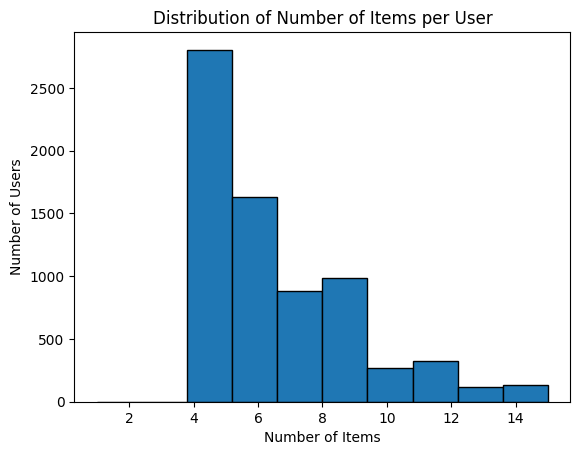

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

items_per_user = df_rec_filtered.groupBy('userId').count().select('count').toPandas()


# Plot the histogram
plt.hist(items_per_user['count'], bins=10, range=(1,15), edgecolor='black')
plt.xlabel('Number of Items')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Items per User')
plt.show()

### Train Test Split

When training recommendation algorithms, the traditional random split of data into training and testing sets may not be suitable. In the context of recommendation systems, we need to handle the unique challenge of ensuring that all users are present in both the training and testing datasets.<br>

To address this issue, a common approach is to perform a **user-level dataset split. Instead of randomly dividing the data at the individual data point level, we mask a certain percentage of items for each user and use these masked items as the testing set**. Specifically, we randomly hide a portion (e.g., 20%) of the items that each user has interacted with in the training set.<br>

This user-level split allows us to ensure that the testing set contains users with diverse preferences, which is critical for evaluating the performance of the recommendation system accurately. By using metrics such as precision and NDCG on the masked items, we can **compare the predicted recommendations with the actual hidden items to assess the quality and effectiveness of the recommendation model**. This method provides a more realistic evaluation of the recommendation system’s performance in a scenario where some user-item interactions are unknown during training but need to be predicted during testing.

In [11]:
# For example, 30% of items will be masked
percent_items_to_mask = 0.3
# Determine the number of items to mask for each user
df_rec_final = df_rec_filtered.withColumn("num_items_to_mask", (col("num_items") * percent_items_to_mask).cast("int"))
# Masks items for each user
df_rec_final = df_rec_final.withColumn("item_rank", rank().over(user_window)) #similar to window function

# Create a StringIndexer model to index the user ID column
indexer_user = StringIndexer(inputCol='userId', outputCol='userIndex').setHandleInvalid("keep")
indexer_item = StringIndexer(inputCol='itemId', outputCol='itemIndex').setHandleInvalid("keep")

# Fit the indexer model to the data and transform the DataFrame
df_rec_final = indexer_user.fit(df_rec_final).transform(df_rec_final)
df_rec_final = indexer_item.fit(df_rec_final).transform(df_rec_final)

# Convert the userIndex column to integer type
df_rec_final = df_rec_final.withColumn('userIndex', df_rec_final['userIndex'].cast('integer'))\
               .withColumn('itemIndex', df_rec_final['itemIndex'].cast('integer'))

#train_test_split, use mask number as threshold of rank
train_df_rec = df_rec_final.filter(col("item_rank") > col("num_items_to_mask"))
test_df_rec = df_rec_final.filter(col("item_rank") <= col("num_items_to_mask"))

From the documentation: there are three strategies regarding how StringIndexer will handle unseen labels when you have fit a StringIndexer on one dataset and then use it to transform another:

**'error'**: throws an exception (which is the default) <br>
**'skip'**: skips the rows containing the unseen labels entirely (removes the rows on the output!) <br>
**'keep'**: puts unseen labels in a special additional bucket, at index numLabels <br>

In [12]:
df_rec_final.show()

+----------+--------------------+------+----------+---------+-----------------+---------+---------+---------+
|    itemId|              userId|rating|popularity|num_items|num_items_to_mask|item_rank|userIndex|itemIndex|
+----------+--------------------+------+----------+---------+-----------------+---------+---------+---------+
|B00HGLLRV2|A0380485C177Q6QQNJIX|     5|       355|        6|                1|        1|     3055|       46|
|B00BGAA3S2|A0380485C177Q6QQNJIX|     5|       425|        6|                1|        2|     3055|       51|
|B00BGA9YZK|A0380485C177Q6QQNJIX|     5|       543|        6|                1|        3|     3055|       12|
|B006PP41Q8|A0380485C177Q6QQNJIX|     5|       153|        6|                1|        4|     3055|      405|
|B006JKASCK|A0380485C177Q6QQNJIX|     5|       301|        6|                1|        5|     3055|      227|
|B000FQ2D5E|A0380485C177Q6QQNJIX|     5|       432|        6|                1|        6|     3055|       22|
|B0050SX7B

Spark has implemented **Alternated Least Squares (ALS)**, an algorithm widely used in the implementation of recommender systems based on Collaborative Filtering<br>
east squares alternation
The name “Alternating Least Squares” comes from the approach of minimizing alternating squared errors. Initially, we fixed the items matrix (Q) and optimized the users matrix (P) to reduce the reconstruction error of the original evaluations.<br>
loss function 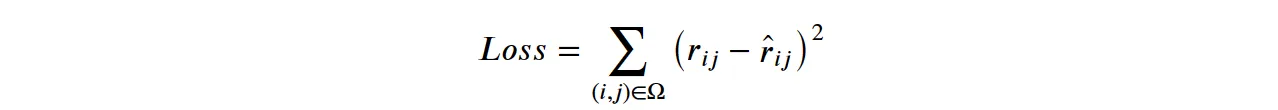

How it works
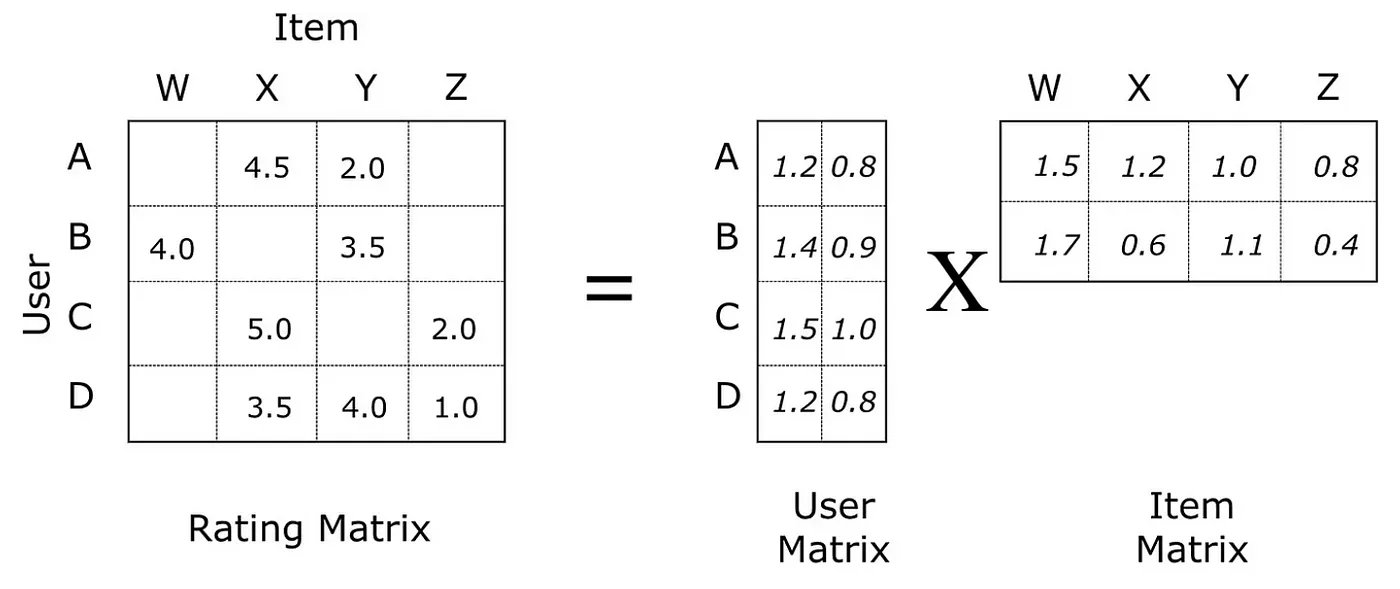

Convergence

The algorithm iterates through these two alternating steps until the user matrix and item matrix reach a convergence point, meaning that the predictions of ratings get as close as possible to the actual ratings given by the users.

Recommendation Generation

After obtaining the optimized user and item matrices, we can use them to make predictions about the ratings a user would give to a specific game. Based on these predictions, we can recommend the highest-rated games that the user has not yet experienced.

**Baseline - Only one latent factors**
One of the best baselines we can use to compare with our recommendation system is **popularity-based**. And this is quite simple to do: Just set the number of latent factors in the ALS algorithm to 1. Let’s understand why this happens:

The ALS model with only 1 latent factor means that the system is representing users and items in a one-dimensional space. This implies that **the model is not learning complex latent features or relationships between users and items. Instead, it considers only one overall dimension that captures the average trend of the rating data.**

In this case, the rating matrix is approximated by a matrix of outer products (i.e., only one outer product) of user and item vectors. As a result, the model simply weights user preferences and item features by the same scalar value, which simplifies the recommendation process significantly.

If all users have similar or identical ratings for a specific item, the ALS model with 1 latent factor will classify that item as popular, because the single latent factor will be equally applied to all users, without considering their individual preferences.



**Regularization** <br>
In the loss function, Spark implements regularization to the ALS, to control overfitting and improve the overall performance of the recommender system. Regularization is a technique that penalizes high magnitude terms in the P and Q matrices during optimization, encouraging the latent vectors to have smaller values and thus preventing the model from overfitting the training data. There are two common types of regularization that can be added to ALS: L2 regularization (also known as Ridge regularization) and L1 regularization (also known as LASSO regularization). The difference between them is in the way the penalty is applied.<br>

L2 Regularization (Ridge): The L2 regularization adds a term to the loss function that is proportional to the sum of squares of the elements of the matrices P and Q. The objective is to force the values of the latent vectors to be small. The loss function with L2 regularization is given by:

L1 Regularization (LASSO): The L1 regularization adds a term to the loss function that is proportional to the sum of the absolute values of the elements of the P and Q matrices. Like the L2 regularization, the L1 regularization also encourages the latent vectors to have smaller values, but in a more sparse way. The loss function with L1 regularization is given by


**Use ALS with Spark - Initialize**<br>
userCol: Specifies the name of the column that contains the user indexes.<br>
**itemCol**: Specifies the name of the column that contains the item indexes (games, in this case).<br>
**ratingCol**: Specifies the name of the column that contains user ratings for the items.<br>
**coldStartStrategy**: Specifies the strategy for handling new users or items during forecasting. In this case, “drop” indicates that new users or items will be dropped.<br>
**nonnegative**: Indicates whether predictions should be restricted to non-negative values.<br>

**Use ALS with Spark - parameter**<br>

**rank**: Specifies the number of latent factors (also called dimensions) of the ALS.
**maxIter**: Specifies the maximum number of iterations that ALS can run during training.
**regParam**: Specifies the regularization term that controls the strength of the penalty to avoid overfitting.

**Cross Validation**
A regression evaluator is created to evaluate the performance of the ALS model. The evaluator will use the metric rmse (Root Mean Squared Error) to calculate the error between the actual evaluations and the model predictions. The CrossValidator object is created to perform cross validation. It uses the param_grid hyperparameter grid, the evaluator evaluator, and divides the data into 3 folds to evaluate model performance.

In [13]:
# Configure the ALS model
als = ALS(userCol='userIndex', itemCol='itemIndex', ratingCol='rating',
          coldStartStrategy='drop', nonnegative=True)


param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [1, 20, 30])\
             .addGrid(als.maxIter, [20])\
             .addGrid(als.regParam, [.05, .15])\
             .build()

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# cv = CrossValidator(
#         estimator=als,
#         estimatorParamMaps=param_grid,
#         evaluator=evaluator,
#         numFolds=3)

model = als.fit(train_df_rec)

# best_model = model.bestModel


In [14]:
print('rank: ', model.rank) #number of latent factor
print('MaxIter: ', model._java_obj.parent().getMaxIter())
print('RegParam: ', model._java_obj.parent().getRegParam())

rank:  10
MaxIter:  10
RegParam:  0.1


In [15]:
# Generate predictions on the test data
predictions = model.transform(test_df_rec)
predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 1 THEN 1 WHEN prediction > 5 THEN 5 ELSE prediction END")) #capped because of rating

evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.2014159193098246


In [16]:
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql.functions import col, collect_list

# Convert the predictions DataFrame to include all predictions per user
# Generate top-k recommendations for each user
userRecs = model.recommendForAllUsers(100)  # Top-100 recommendations for each user

# Prepare the input for RankingMetrics
user_ground_truth = test_df_rec.groupby('userIndex').agg(collect_list('itemIndex').alias('ground_truth_items')) #把item归到一列中
user_train_items = train_df_rec.groupby('userIndex').agg(collect_list('itemIndex').alias('train_items'))

# Join the recommendations and ground truth data on the user ID
user_eval = userRecs.join(user_ground_truth, on='userIndex').join(user_train_items, on='userIndex') \
    .select('userIndex', 'recommendations.itemIndex', 'ground_truth_items', 'train_items', 'recommendations.rating')
user_eval = user_eval.toPandas()
user_eval['itemIndex_filtered'] = user_eval.apply(lambda x:[b for (b,z) in zip(x.itemIndex, x.rating) if b not in x.train_items], axis=1)
user_eval['rating_filtered'] = user_eval.apply(lambda x:[z for (b,z) in zip(x.itemIndex, x.rating) if b not in x.train_items], axis=1)

In [27]:
userRecs.filter(col('userIndex')==148).select('recommendations').show()

+--------------------+
|     recommendations|
+--------------------+
|[{399, 4.79541}, ...|
+--------------------+



In [18]:
user_eval

,userIndex,itemIndex,ground_truth_items,train_items,rating,itemIndex_filtered,rating_filtered
0,148,"[399, 107, 489, 101, 459, 29, 434, 92, 194, 16...","[82, 206, 237, 224, 194, 95]","[101, 281, 281, 19, 19, 181, 250, 280, 328, 86...","[4.79541015625, 4.713661193847656, 4.656005382...","[399, 489, 459, 29, 434, 92, 194, 166, 451, 32...","[4.79541015625, 4.656005382537842, 4.544713973..."
1,463,"[489, 166, 414, 262, 217, 290, 373, 284, 297, ...","[289, 221, 29, 35]","[23, 179, 7, 216, 112, 88, 106, 140, 18, 196]","[5.96323299407959, 5.804080486297607, 5.770219...","[489, 166, 414, 262, 217, 290, 373, 284, 297, ...","[5.96323299407959, 5.804080486297607, 5.770219..."
2,471,"[476, 166, 410, 319, 491, 489, 169, 262, 40, 3...","[333, 141, 90, 89]","[88, 18, 12, 362, 372, 91, 99, 324, 324, 8]","[5.8798747062683105, 5.748537540435791, 5.7314...","[476, 166, 410, 319, 491, 489, 169, 262, 40, 3...","[5.8798747062683105, 5.748537540435791, 5.7314..."
3,496,"[476, 414, 262, 489, 323, 319, 284, 166, 169, ...","[4, 67, 441]","[51, 235, 116, 371, 58, 212, 109, 6, 6, 8]","[5.58344030380249, 5.573465824127197, 5.517517...","[476, 414, 262, 489, 323, 319, 284, 166, 169, ...","[5.58344030380249, 5.573465824127197, 5.517517..."
4,833,"[476, 424, 425, 490, 161, 56, 310, 212, 481, 3...","[25, 386, 134]","[4, 88, 55, 200, 34, 18, 51, 62]","[6.5254316329956055, 6.152369022369385, 6.0799...","[476, 424, 425, 490, 161, 56, 310, 212, 481, 3...","[6.5254316329956055, 6.152369022369385, 6.0799..."
...,...,...,...,...,...,...,...
7487,6721,"[410, 491, 265, 166, 262, 489, 78, 40, 226, 44...",[17],"[57, 47, 69, 79]","[5.45684814453125, 5.312335968017578, 5.311764...","[410, 491, 265, 166, 262, 489, 78, 40, 226, 44...","[5.45684814453125, 5.312335968017578, 5.311764..."
7488,6819,"[91, 489, 410, 40, 166, 35, 100, 491, 426, 262...",[258],"[165, 127, 7, 140]","[5.224695682525635, 5.185373783111572, 5.16164...","[91, 489, 410, 40, 166, 35, 100, 491, 426, 262...","[5.224695682525635, 5.185373783111572, 5.16164..."
7489,7166,"[489, 166, 414, 426, 262, 397, 131, 336, 297, ...",[106],"[115, 355, 68, 310]","[5.571713924407959, 5.38287353515625, 5.365605...","[489, 166, 414, 426, 262, 397, 131, 336, 297, ...","[5.571713924407959, 5.38287353515625, 5.365605..."
7490,7466,"[52, 275, 169, 203, 103, 123, 346, 464, 331, 3...",[80],"[156, 277, 23, 153]","[4.452399253845215, 4.4307990074157715, 4.4200...","[52, 275, 169, 203, 103, 123, 346, 464, 331, 3...","[4.452399253845215, 4.4307990074157715, 4.4200..."


Evaluation metrics
There are several metrics that we can use to evaluate recommender systems. These metrics measure different aspects of system performance and are useful for understanding how recommendations compare to users’ real preferences and interests.

Precision@k is a metric that measures the proportion of relevant items that were recommended in the first k items of the recommendation list. It focuses on the hit rate of the recommendations in relation to the total number of recommended items. The formula for calculating precision@k is as follows:

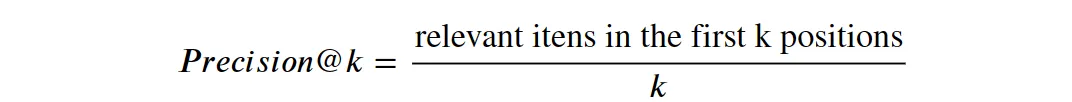

Here, “relevant items” are the items that the user interacted with positively or rated highly. Therefore, precision@k measures the ability of the recommender system to provide relevant recommendations on the first k items in the list.

Recall@k is a metric that measures the proportion of relevant items that were recommended against the total number of relevant items in the database. Unlike precision@k, recall@k focuses on the recall rate of relevant items among all available relevant items. The formula for calculating the recall@k is as follows:

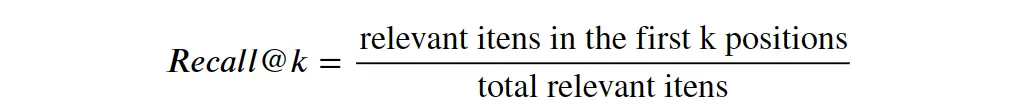

The recall@k is important to assess whether the recommender system is being able to retrieve all relevant items in your recommendation list, regardless of order.

NDCG (Normalized Discounted Cumulative Gain): The NDCG is a metric that takes into account the relevance of recommended items and the position in which they were recommended. It values relevant recommendations that are closer to the top of the recommendation list, assigning higher scores to relevant items in higher positions. The formula for calculating the NDCG is as follows:

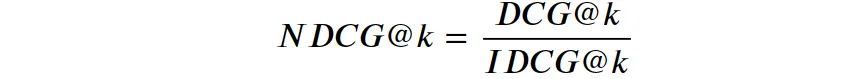

where DCG@k (Discounted Cumulative Gain) is calculated as:

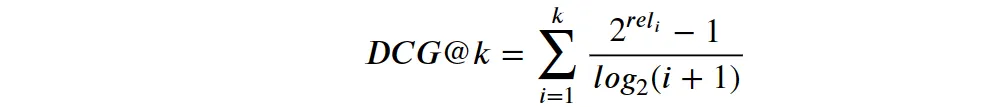

and **IDCG@k (Ideal Discounted Cumulative Gain)** is the ideal DCG@k value, obtained when all k recommended items are relevant.

The **NDCG@k** varies between 0 and 1, where 1 indicates that all recommendations are perfectly relevant and are positioned at the top of the list.

We use each of these metrics, we will use the masked items from the test base as relevant items. If the system recommended 2 items that were in the user test base in the top 5 positions, your precision@5 is 2/5. If that user had 7 masked items, the recall@5 is 2/7. If a recommendation system has placed these items in first and second place and another system in fourth and fifth, the precision@k will be the same, but the NDCG takes into account the position of the items, penalizing lower positions. Therefore, the NDCG@5 for the first recommender system is approximately 1.00, indicating that all relevant recommendations are positioned in the best positions. The NDCG@5 for the second recommendation system is approximately 0.55, indicating that the relevant recommendations are positioned below what the ideal system could provide. An NDCG@5 of 1.00 is the ideal value, indicating that all relevant recommendations are in the top positions and have high relevance.

Generally speaking, we will evaluate the recommender system using the average NDCG, which averages the NDCG for all users in the test set. and the **Mean Average Precision (MAP)**. The MAP is a summary measure of precision at different cutoff points (k) in the recommendation list. To calculate the MAP, it is first necessary to calculate the Average Precision for each user.

Average Precision is a metric that considers the relevance of recommended items along the recommendation list. It measures the proportion of relevant items found in each recommendation list position up to item k, and these proportions are averaged for each user. Then the MAP is calculated as the average of the Mean Precision for all users in the test set.

In [28]:
import numpy as np
import math
def score(predicted, actual, metric):
        """
        Parameters
        ----------
        predicted : List
            List of predicted apps.
        actual : List
            List of masked apps.
        metric : 'precision' or 'ndcg'
            A valid metric for recommendation.
        Raises
        -----
        Returns
        -------
        m : float
            score.
        """
        valid_metrics = ['precision', 'ndcg']
        if metric not in valid_metrics:
            raise Exception(f"Choose one valid baseline in the list: {valid_metrics}")
        if metric == 'precision':
            m = np.mean([float(len(set(predicted[:k])
                                               & set(actual))) / float(k)
                                     for k in range(1,len(actual)+1)])
        if metric == 'ndcg':
            v = [1 if i in actual else 0 for i in predicted]
            v_2 = [1 for i in actual]
            dcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v)])
            idcg = sum([(2**i-1)/math.log(k+2,2) for (k,i) in enumerate(v_2)])
            m = dcg/idcg
        return m

user_eval['precision'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'precision'), axis=1)
user_eval['NDCG'] = user_eval.apply(lambda x: score(x.itemIndex_filtered, x.ground_truth_items, 'ndcg'), axis=1)

MAP = user_eval.precision.mean()
avg_NDCG = user_eval.NDCG.mean()

explaination of MAG
https://www.evidentlyai.com/ranking-metrics/mean-average-precision-map

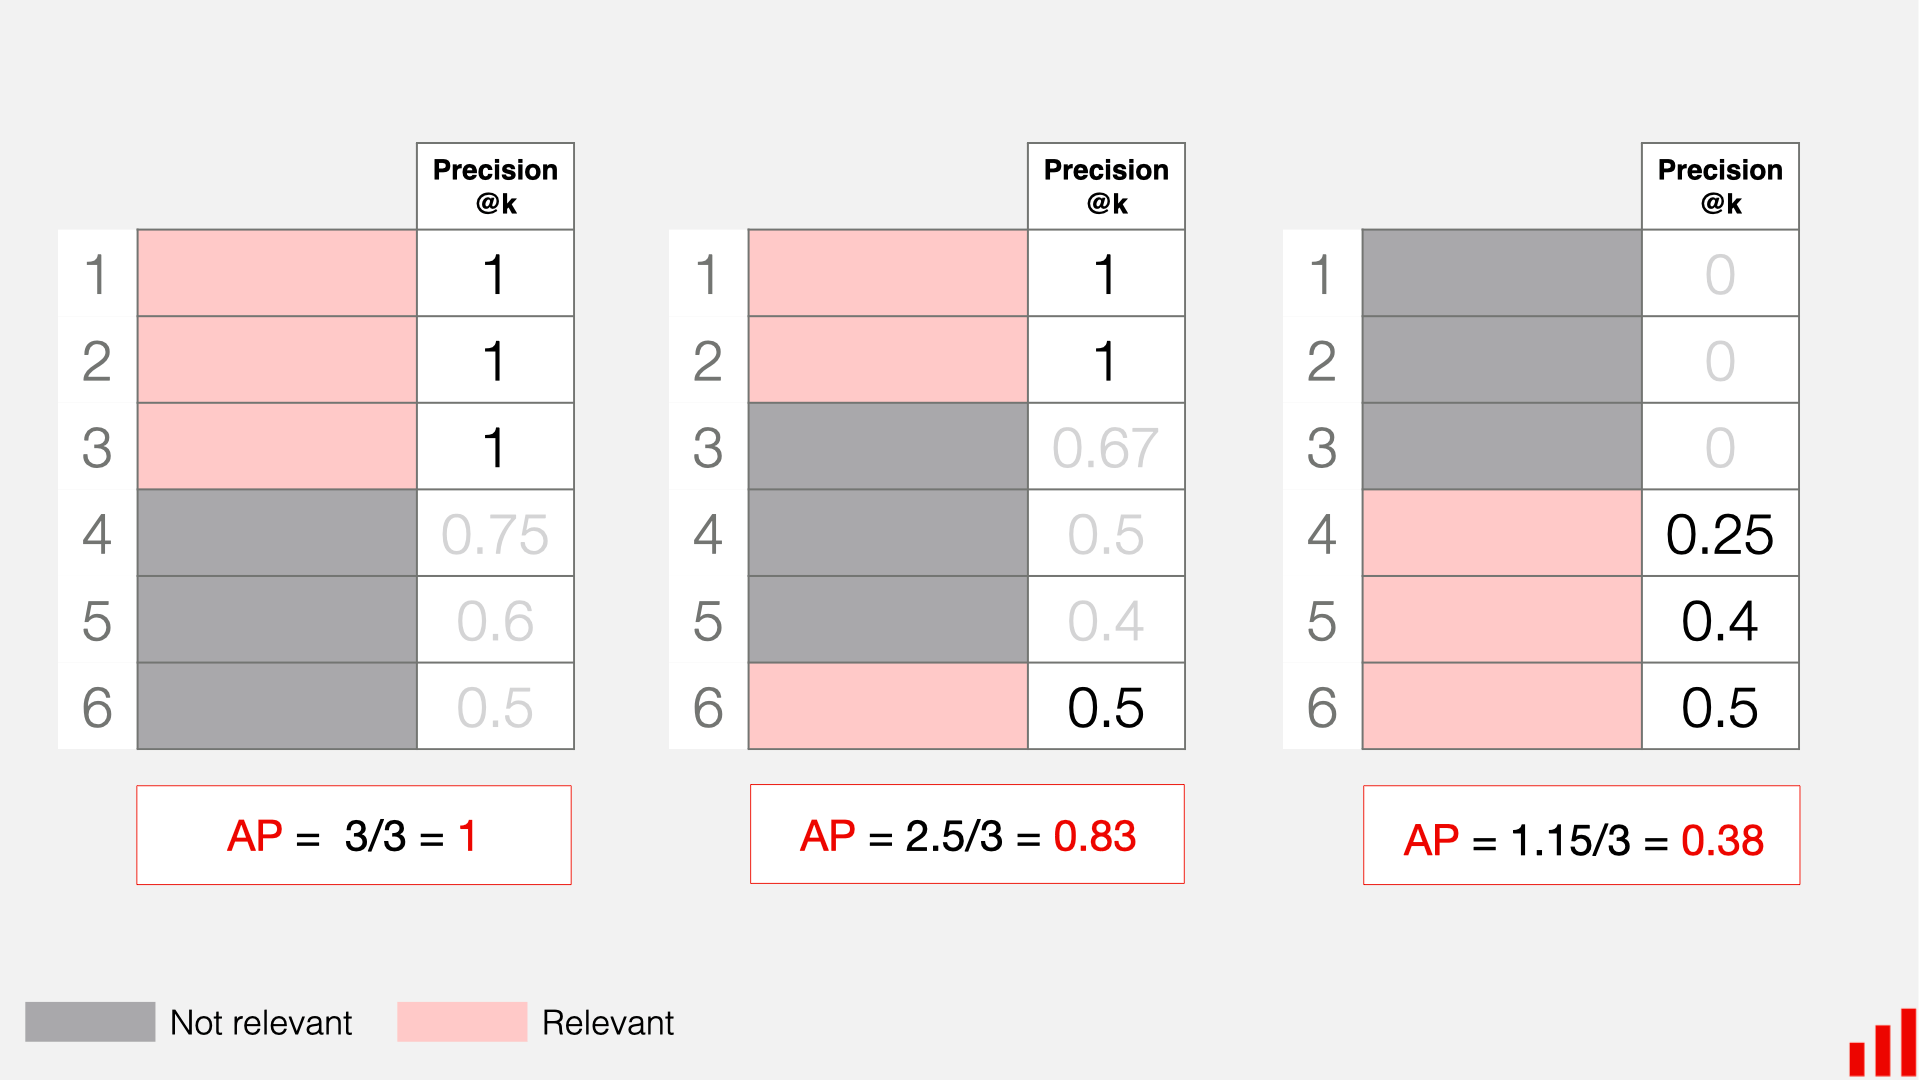

In [30]:
MAP

0.004913291246013612

In [29]:
avg_NDCG

0.05641360473686938